# Tutorial [Raytracing em um final de semana](https://raytracing.github.io/books/RayTracingInOneWeekend.html#rays,asimplecamera,andbackground)

Observações: 

- As **etapas 1 e 2** estão implementadas no diretório **Atividade 01**

- A **etapa 3** está implementada em **Atividade 02**

- A **etapa 4.1** está implementada em **Ray.py** no mesmo repositório

## Importações

In [20]:
import sys
import os

import numpy as np
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

from Ray import Ray
from Atividade02.src.vectorized.Vec3 import Vec3, Point3, Color
from Atividade01.src.ImageIO import ImageWriter
from Atividade01.src.Image import Image

## 4.2 Sending Rays Into the scene 

In [21]:
aspect_ratio = 16.0 / 9.0
image_width = 400

image_height = int(image_width / aspect_ratio)
if image_height < 1:
    image_height = 1

viewport_height = 2.0
viewport_width = viewport_height * (image_width / image_height)
# OBS: viewport_width: não está usando a variável aspect_ratio, pois a variável aspect_ratio é a proporção ideal da imagem, porém, arredondamos image_height para inteiro, podendo assim perder um pouco de precisão na proporção da imagem.

# PAREI NA CAMERA...

Espaçamento horizontal dos pixels:
0.008888888888888889 0.0 0.0
Espaçamento vertical dos pixels:
0.0 -0.008888888888888889 0.0


100%|██████████| 225/225 [00:14<00:00, 15.23it/s]


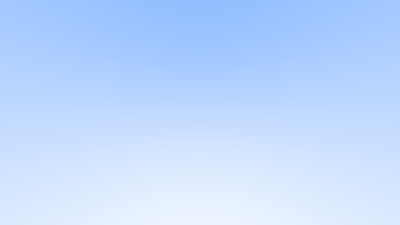

In [22]:
def ray_color(ray: Ray):
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

def raytrace_pipeline(filename: str):
    focal_length = 1.0
    camera_center = Point3([0, 0, 0])

    viewport_u = Vec3([viewport_width, 0, 0])
    viewport_v = Vec3([0, -viewport_height, 0])

    pixel_delta_u = viewport_u / image_width
    pixel_delta_v = viewport_v / image_height

    print('Espaçamento horizontal dos pixels:')
    print(pixel_delta_u)
    print('Espaçamento vertical dos pixels:')
    print(pixel_delta_v)

    # If pixels are spaced the same distance horizontally as they are vertically, the viewport that bounds them will have the same aspect ratio as the rendered image.
    # Como estamos definindo o viewport para ter o mesmo aspect ratio da imagem (quantidade de pixels), então, os pixels terão o mesmo espaçamento horizontal e vertical.

    viewport_upper_left = camera_center - Vec3([0, 0, focal_length]) - (viewport_u / 2) - (viewport_v / 2)
    pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)
    # Precisa adicionar 0,5 da distancia de separação dos pixels. O canto esquerdo do viewport não é o mesmo que o ponto 0,0 da imagem. O viewport precisa ter uma borda de 0,5 espaçamento de pixel para cada lado.


    # CRIAR MATRIZ
    image = Image(image_width, image_height)
    for j in tqdm(range(image_height)):
        for i in range(image_width):
            pixel_center = pixel00_loc + (i * pixel_delta_u) + (j * pixel_delta_v)
            ray_direction = pixel_center - camera_center
            ray = Ray(camera_center, ray_direction)

            pixel_color = ray_color(ray)
            image[j, i] = pixel_color

    img_writer = ImageWriter(image)
    img_writer.save(filename)
    display(img_writer.image)

raytrace_pipeline('1-degrade-raytrace.png')
# A imagem sairá com degradê para os dois lados, pois está utilizando o vetor unidade, e não o próprio y diretamente
# Logo, as outras coordenadas (x e z) influenciam no vetor unidade, fazendo com que o y não seja o unico vetor que influencia na cor.

## 5.2 Creating Our First Raytraced Image

Espaçamento horizontal dos pixels:
0.008888888888888889 0.0 0.0
Espaçamento vertical dos pixels:
0.0 -0.008888888888888889 0.0


100%|██████████| 225/225 [00:13<00:00, 17.14it/s]


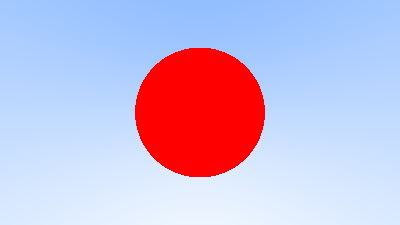

In [23]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c
    return discriminant >= 0

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    if hit_sphere(Point3([0, 0, -1]), 0.5, ray):
        return Color([1, 0, 0])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('2-first-sphere.png')

## 6.1 Shading with Surface Normals

Espaçamento horizontal dos pixels:
0.008888888888888889 0.0 0.0
Espaçamento vertical dos pixels:
0.0 -0.008888888888888889 0.0


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:11<00:00, 19.80it/s]


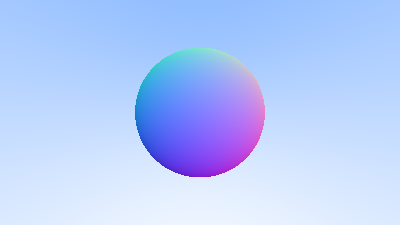

In [24]:
def hit_sphere(center: Point3, radius: float, ray: Ray):
    oc = ray.origin - center
    a = ray.direction.dot(ray.direction)
    b = 2 * oc.dot(ray.direction)
    c = oc.dot(oc) - radius ** 2

    discriminant = b ** 2 - 4 * a * c

    if discriminant < 0:
        return -1
    else:
        return (-b -np.sqrt(discriminant)) / (2.0 * a)

def ray_color(ray: Ray):
    # Se acertar a esfera, pinta de vermelho
    t = hit_sphere(Point3([0, 0, -1]), 0.5, ray)
    if t > 0:
        normal = (ray.at(t) - Vec3([0, 0, -1])).unit_vector()
        return 0.5 * Color([normal.x + 1, normal.y + 1, normal.z + 1])
    
    # Se não, pinta com o fundo (degradê)
    unit_direction = ray.direction.unit_vector()
    a = 0.5 * (unit_direction.y + 1.0)
    return (1.0 - a) * Color([1.0, 1.0, 1.0]) + a * Color([0.5, 0.7, 1.0])

raytrace_pipeline('3-sphere-with-normals.png')